# Fit BAO peak from input correlation function

In [1]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from cosmoprimo import *

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import split_density, compute_densitySplit_CCF
from densitysplit.pk_model import *
from densitysplit.utils import *
from densitysplit.corr_func import *

# To activate logging
setup_logging()

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
#catalog_name = 'AbacusSummit_1Gpc_z1.175'
#bias = 1.8

catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

In [4]:
z = catalog.redshift

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()
f = bg.Omega_m(z)**0.55

## Load correlation function poles

In [5]:
ells = [0]
nells = len(ells)

### Density split

In [6]:
nsplits = 2
abacus_split_results = np.load(output_dir+catalog.name+'_densitySplit_dg_CCFs_cellsize10_randomsize4.npy', allow_pickle=True)
mocks_split_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_densitySplit_dg_CCF_cellsize10_randomsize4_all.npy', allow_pickle=True)

In [7]:
_, split_cov = get_split_poles(mocks_split_results, ells, nsplits)
split_xiell = [abacus_split_results[split].get_corr(ells=ells, return_sep=False) for split in range(nsplits)]
split_cov /= 8

In [8]:
s, _ = abacus_split_results[0].get_corr(ells=ells, return_sep=True)

## Set power spectrum model

In [9]:
pk_model = PkModel(sep=s, ells=ells, xiell=split_xiell, cov=split_cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=True, nsplits=2)
pk_model.set_pk_model()
default_params = {'f': 0., 'b1': 2., 'b2': 2., 'alpha_par': 1., 'alpha_perp': 1., 'sigma_par': 5., 'sigma_perp': 5., 'sigma_s': 0.}
pk_model.set_default_params(**default_params)
#pk_model.plot_model()

## Fit model to data

In [10]:
# Remove small scales (linear model not valid at small scales)
s_lower_limit = 50 # Mpc/h

# initialize parameters
broadband_coeffs = np.tile([0., 0., 0.], nells)
params_init = {'b1': 2., 'b2': 2., 'alpha_par': 1., 'sigma_par': 6., 'broadband_coeffs1': broadband_coeffs, 'broadband_coeffs2': broadband_coeffs}

pk_model.fit_splits(fit_params_init=params_init, s_lower_limit=s_lower_limit)

Optimal parameters:
{'b1': 1.205045037567775, 'b2': 2.66491989386165, 'alpha_par': 1.0068013988210731, 'sigma_par': 7.009026618469855, 'broadband_coeffs1': array([-2.12755047e+00,  4.27343710e-02, -1.91798996e-04]), 'broadband_coeffs2': array([ 8.47393455e+00, -1.86729381e-01,  9.13934745e-04])}

Covariance matrix:
[[ 3.01297209e-03  5.92719831e-03  6.61944642e-05  1.80225371e-02
   1.05074555e-01 -1.36723946e-03  3.90172050e-06 -4.57713211e-01
   5.97533215e-03 -1.72223995e-05]
 [ 5.92719831e-03  1.20345601e-02  1.51410500e-04  3.77007744e-02
   2.08162015e-01 -2.72633149e-03  7.87083081e-06 -9.26157388e-01
   1.20750823e-02 -3.47650553e-05]
 [ 6.61944642e-05  1.51410500e-04  1.17270122e-04  7.08640664e-04
   1.13112964e-03 -3.37390740e-05  1.63660903e-07 -4.53611605e-03
   1.31045988e-04 -5.96592273e-07]
 [ 1.80225371e-02  3.77007744e-02  7.08640664e-04  2.05693943e-01
   6.23138198e-01 -8.16208395e-03  2.29069750e-05 -2.84414310e+00
   3.69322925e-02 -1.02592678e-04]
 [ 1.05074555e-

({'b1': 1.205045037567775,
  'b2': 2.66491989386165,
  'alpha_par': 1.0068013988210731,
  'sigma_par': 7.009026618469855,
  'broadband_coeffs1': array([-2.12755047e+00,  4.27343710e-02, -1.91798996e-04]),
  'broadband_coeffs2': array([ 8.47393455e+00, -1.86729381e-01,  9.13934745e-04])},
 array([[ 3.01297209e-03,  5.92719831e-03,  6.61944642e-05,
          1.80225371e-02,  1.05074555e-01, -1.36723946e-03,
          3.90172050e-06, -4.57713211e-01,  5.97533215e-03,
         -1.72223995e-05],
        [ 5.92719831e-03,  1.20345601e-02,  1.51410500e-04,
          3.77007744e-02,  2.08162015e-01, -2.72633149e-03,
          7.87083081e-06, -9.26157388e-01,  1.20750823e-02,
         -3.47650553e-05],
        [ 6.61944642e-05,  1.51410500e-04,  1.17270122e-04,
          7.08640664e-04,  1.13112964e-03, -3.37390740e-05,
          1.63660903e-07, -4.53611605e-03,  1.31045988e-04,
         -5.96592273e-07],
        [ 1.80225371e-02,  3.77007744e-02,  7.08640664e-04,
          2.05693943e-01,  6.2

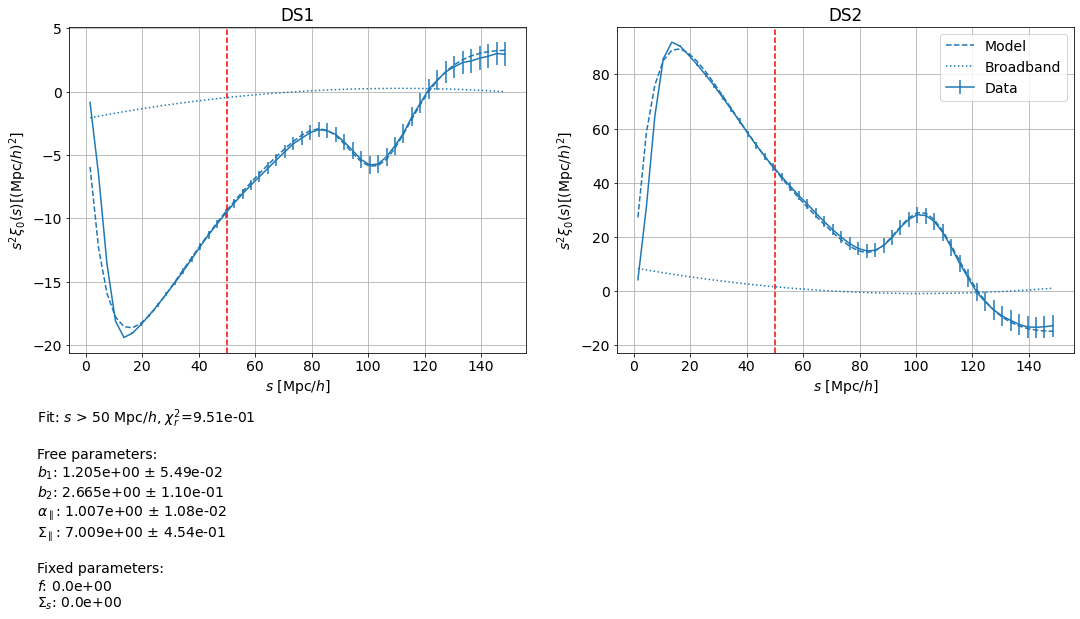

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey = False)

pk_model.plot_model_splits(fig=fig, axes=axes, plot_data=True, show_info=True, show_broadband=True)
#plt.title('DS1 (randoms-halos)')
plt.show()